In [125]:
from linearmodels.panel import PooledOLS, PanelOLS

import statsmodels.api as sm
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from statsmodels.iolib.summary2 import summary_col

## Read in data

In [93]:
us_daily = pd.read_csv("data/cleaned/daily_df.csv", index_col=0)
us_daily["date"] = pd.to_datetime(us_daily["date"])
us_daily = us_daily.set_index("date")

In [94]:
us_monthly = us_daily.groupby([pd.Grouper(freq='M'), 'state']).mean()
us_monthly
us_monthly = pd.DataFrame(us_monthly.to_records())

In [142]:
us_daily.loc[us_daily["state"] == "Illinois", ["hospitalizedIncrease"]].sum()

hospitalizedIncrease    0
dtype: int64

In [95]:
micperceptions =  pd.read_csv("data/cleaned/misperception_state_inferred.csv", index_col=0)
micperceptions = pd.DataFrame(micperceptions.to_records())
micperceptions.columns = ["state", "pc_misperception"]
micperceptions.pc_misperception = micperceptions.pc_misperception.str.rstrip('%').astype('float') / 100.0

In [96]:
us_cross_sectional = us_daily.loc[(us_daily.index >= "2020-03-01") & (us_daily.index <= "2021-01-31")].groupby(["state"]).mean()

In [97]:
us_cross_sectional = pd.merge(us_cross_sectional, micperceptions, on="state")

In [98]:
reported_compliance = pd.read_csv("data/covidstates/beh_2.csv", index_col=0)

US_state_abb = pd.read_csv("data/US_state_abb.csv")
US_state_abb.columns = ["state", "state_abb"]
reported_compliance = pd.merge(reported_compliance, US_state_abb, on="state_abb", how="left")


In [99]:
reported_compliance.columns = ["state_abb", "not_at_all", "not_very", "somewhat", "very", "error_margin", "N", "wave", "state"]

In [100]:
reported_compliance_cross_sectional = reported_compliance.groupby(["state"]).mean()
us_cross_sectional = pd.merge(us_cross_sectional, reported_compliance_cross_sectional, on="state", how="left")

In [101]:
us_cross_sectional[["state", "pc_misperception"]].sort_values("pc_misperception")

,state,pc_misperception
44,Vermont,0.090
10,Hawaii,0.090
49,Wyoming,0.110
37,Pennsylvania,0.110
36,Oregon,0.110
6,Connecticut,0.110
7,Delaware,0.110
11,Idaho,0.110
20,Massachusetts,0.110
48,Wisconsin,0.125


## Disease outcomes

In [102]:
us_cross_sectional.columns

Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative',
       'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently',
       'onVentilatorCumulative', 'recovered', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg',
       'dataQualityGrade', 'deathIncrease', 'hospitalizedIncrease',
       'commercialScore', 'negativeRegularScore', 'negativeScore',
       'positive

In [103]:
us_cross_sectional["deaths_pth"] = 1000 * us_cross_sectional["deathIncrease"] / us_cross_sectional["pop_2019"]

In [104]:
us_cross_sectional["hospitalized_pth"] = 1000 * us_cross_sectional["hospitalizedIncrease"] / us_cross_sectional["pop_2019"]

In [105]:
us_cross_sectional["positivity_rate"] = us_cross_sectional["positiveIncrease"] / us_cross_sectional["totalTestResultsIncrease"]

There is generally positive relationship between the level of misperceptions and severity of disease outcomes. 

In [106]:
cross_sectional_reg_1_posrate = smf.ols('positivity_rate ~ pc_misperception', data=us_cross_sectional).fit()
cross_sectional_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.453
Date:                Sat, 20 Feb 2021   Prob (F-statistic):             0.0401
Time:                        19:22:54   Log-Likelihood:                 73.832
No. Observations:                  50   AIC:                            -143.7
Df Residuals:                      48   BIC:                            -139.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0239      0.058     -0.411      0.683      -0.141       0.093
pc_misperception     0.8763      0.415      2.110      0.040       0.041       1.711
==============================================================================
Omnibus:                       26.837   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.997
Skew:                           1.716   Prob(JB):                     1.03e-10
Kurtosis:                       6.208   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
cross_sectional_reg_1_dea = smf.ols('deaths_pth ~ pc_misperception', data=us_cross_sectional).fit()
cross_sectional_reg_1_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.462
Date:                Sat, 20 Feb 2021   Prob (F-statistic):             0.0399
Time:                        19:22:56   Log-Likelihood:                 254.97
No. Observations:                  50   AIC:                            -505.9
Df Residuals:                      48   BIC:                            -502.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0005      0.002      0.339      0.736      -0.003       0.004
pc_misperception     0.0234      0.011      2.112      0.040       0.001       0.046
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.754
Skew:                           0.242   Prob(JB):                        0.686
Kurtosis:                       2.643   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
print(summary_col([cross_sectional_reg_1_posrate, cross_sectional_reg_1_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                  & positivity\_rate & deaths\_pth  \\
\hline
Intercept         & -0.024           & 0.001        \\
                  & (0.058)          & (0.002)      \\
pc\_misperception & 0.876**          & 0.023**      \\
                  & (0.415)          & (0.011)      \\
R-squared         & 0.085            & 0.085        \\
R-squared Adj.    & 0.066            & 0.066        \\
\hline
\end{tabular}
\end{center}
\end{table}


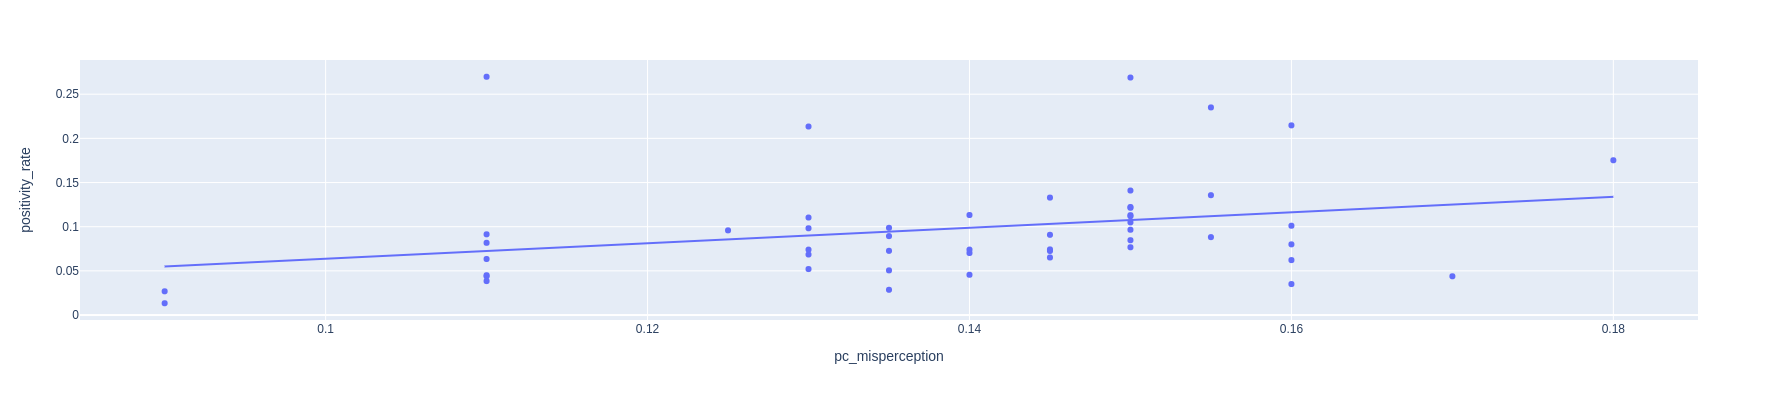

In [131]:
fig = px.scatter(us_cross_sectional, x="pc_misperception", y="positivity_rate", hover_data=["state"], trendline="ols", width=400, height=400)
fig.show()

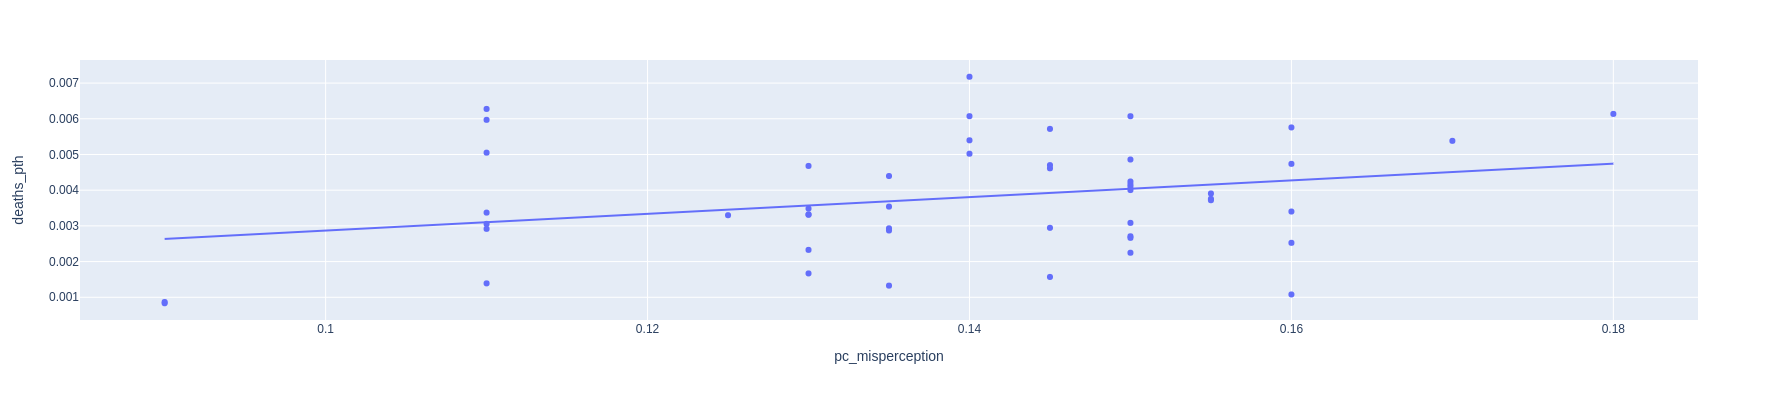

In [133]:
fig = px.scatter(us_cross_sectional, x="pc_misperception", y="deaths_pth", hover_data=["state"], trendline="ols", width=400, height=400)
fig.show()

In [147]:
cross_sectional_reg_2_posrate = smf.ols('positivity_rate ~ pc_misperception + StringencyIndex + White', data=us_cross_sectional).fit()
cross_sectional_reg_2_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           2.70e-06
Time:                        20:09:33   Log-Likelihood:                 87.007
No. Observations:                  50   AIC:                            -166.0
Df Residuals:                      46   BIC:                            -158.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2381      0.092      2.582      0.013       0.053       0.424
pc_misperception     0.3726      0.346      1.076      0.288      -0.325       1.070
StringencyIndex     -0.0036      0.001     -5.440      0.000      -0.005      -0.002
White               -0.0117      0.058     -0.201      0.841      -0.128       0.105
==============================================================================
Omnibus:                       28.594   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.948
Skew:                           1.619   Prob(JB):                     1.30e-14
Kurtosis:                       7.496   Cond. No.                     2.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [148]:
cross_sectional_reg_2_dea = smf.ols('deaths_pth ~ pc_misperception + StringencyIndex + White', data=us_cross_sectional).fit()
cross_sectional_reg_2_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.931
Date:                Sat, 20 Feb 2021   Prob (F-statistic):              0.138
Time:                        20:09:36   Log-Likelihood:                 255.71
No. Observations:                  50   AIC:                            -503.4
Df Residuals:                      46   BIC:                            -495.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0034      0.003      1.069      0.290      -0.003       0.010
pc_misperception     0.0188      0.012      1.587      0.119      -0.005       0.043
StringencyIndex  -2.651e-05   2.29e-05     -1.157      0.253   -7.26e-05    1.96e-05
White               -0.0011      0.002     -0.563      0.576      -0.005       0.003
==============================================================================
Omnibus:                        1.165   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                0.995
Skew:                           0.338   Prob(JB):                        0.608
Kurtosis:                       2.852   Cond. No.                     2.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [165]:
cross_sectional_reg_3_posrate = smf.ols('positivity_rate ~ pc_misperception + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.143
Date:                Sat, 20 Feb 2021   Prob (F-statistic):              0.108
Time:                        20:18:23   Log-Likelihood:                 74.885
No. Observations:                  50   AIC:                            -141.8
Df Residuals:                      46   BIC:                            -134.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0442      0.116     -0.382      0.704      -0.277       0.188
pc_misperception      0.8958      0.427      2.099      0.041       0.037       1.755
White                 0.0635      0.076      0.841      0.405      -0.089       0.216
Urbanization_rate    -0.0004      0.001     -0.741      0.463      -0.002       0.001
==============================================================================
Omnibus:                       21.404   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.318
Skew:                           1.439   Prob(JB):                     1.58e-07
Kurtosis:                       5.599   Cond. No.                     4.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [166]:
cross_sectional_reg_3_dea = smf.ols('deaths_pth ~ pc_misperception + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     2.572
Date:                Sat, 20 Feb 2021   Prob (F-statistic):             0.0655
Time:                        20:18:23   Log-Likelihood:                 256.63
No. Observations:                  50   AIC:                            -505.3
Df Residuals:                      46   BIC:                            -497.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0026      0.003     -0.866      0.391      -0.009       0.003
pc_misperception      0.0266      0.011      2.358      0.023       0.004       0.049
White                 0.0009      0.002      0.435      0.665      -0.003       0.005
Urbanization_rate   2.78e-05   1.58e-05      1.760      0.085      -4e-06    5.96e-05
==============================================================================
Omnibus:                        0.817   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.665   Jarque-Bera (JB):                0.832
Skew:                           0.119   Prob(JB):                        0.660
Kurtosis:                       2.415   Cond. No.                     4.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [181]:
print(summary_col([cross_sectional_reg_3_posrate, cross_sectional_reg_3_dea, cross_sectional_reg_4_posrate, cross_sectional_reg_4_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                              & positivity\_rate I & deaths\_pth I & positivity\_rate II & deaths\_pth II  \\
\hline
Intercept                     & -0.044             & -0.003        & 0.078               & -0.002          \\
                              & (0.116)            & (0.003)       & (0.125)             & (0.003)         \\
Percent\_bachelor\_or\_higher &                    &               & -0.004**            & -0.000          \\
                              &                    &               & (0.002)             & (0.000)         \\
R-squared                     & 0.123              & 0.144         & 0.202               & 0.146           \\
R-squared Adj.                & 0.065              & 0.088         & 0.131               & 0.071           \\
Urbanization\_rate            & -0.000             & 0.000*        & 0.000               & 0.000*          \\
                              & (0

In [ ]:
'Percent_less_than_high_school',
       'Percent_bachelor_or_higher', 'Percent_some_college_or_associate',
       'Percent_high_school_only', 'AverageTemperature', 'Urbanization_rate'

In [178]:
cross_sectional_reg_4_posrate = smf.ols('positivity_rate ~ pc_misperception + White + Urbanization_rate + Percent_bachelor_or_higher', data=us_cross_sectional).fit()
cross_sectional_reg_4_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     2.849
Date:                Sat, 20 Feb 2021   Prob (F-statistic):             0.0345
Time:                        20:24:31   Log-Likelihood:                 77.258
No. Observations:                  50   AIC:                            -144.5
Df Residuals:                      45   BIC:                            -135.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0775      0.125      0.618      0.539      -0.175       0.330
pc_misperception               0.5040      0.451      1.117      0.270      -0.405       1.413
White                          0.0762      0.073      1.043      0.302      -0.071       0.223
Urbanization_rate              0.0002      0.001      0.252      0.802      -0.001       0.001
Percent_bachelor_or_higher    -0.0040      0.002     -2.117      0.040      -0.008      -0.000
==============================================================================
Omnibus:                       21.571   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.793
Skew:                           1.482   Prob(JB):                     2.06e-07
Kurtosis:                       5.450   Cond. No.                     4.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [179]:
cross_sectional_reg_4_dea = smf.ols('deaths_pth ~ pc_misperception + White + Urbanization_rate + Percent_bachelor_or_higher', data=us_cross_sectional).fit()
cross_sectional_reg_4_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1.931
Date:                Sat, 20 Feb 2021   Prob (F-statistic):              0.122
Time:                        20:24:36   Log-Likelihood:                 256.71
No. Observations:                  50   AIC:                            -503.4
Df Residuals:                      45   BIC:                            -493.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0020      0.003     -0.586      0.561      -0.009       0.005
pc_misperception               0.0246      0.012      1.972      0.055      -0.001       0.050
White                          0.0009      0.002      0.462      0.647      -0.003       0.005
Urbanization_rate           3.085e-05   1.78e-05      1.733      0.090      -5e-06    6.67e-05
Percent_bachelor_or_higher     -2e-05    5.2e-05     -0.385      0.702      -0.000    8.46e-05
==============================================================================
Omnibus:                        0.663   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.775
Skew:                           0.179   Prob(JB):                        0.679
Kurtosis:                       2.506   Cond. No.                     4.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [180]:
print(summary_col([cross_sectional_reg_4_posrate, cross_sectional_reg_4_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                              & positivity\_rate & deaths\_pth  \\
\hline
Intercept                     & 0.078            & -0.002       \\
                              & (0.125)          & (0.003)      \\
pc\_misperception             & 0.504            & 0.025*       \\
                              & (0.451)          & (0.012)      \\
White                         & 0.076            & 0.001        \\
                              & (0.073)          & (0.002)      \\
Urbanization\_rate            & 0.000            & 0.000*       \\
                              & (0.001)          & (0.000)      \\
Percent\_bachelor\_or\_higher & -0.004**         & -0.000       \\
                              & (0.002)          & (0.000)      \\
R-squared                     & 0.202            & 0.146        \\
R-squared Adj.                & 0.131            & 0.071        \\
\hline
\end{tabular}
\end{center}
\end{table}

Nothing really interesting here. 

## Relationship between misperception and mobility

In [50]:
cross_sectional_reg_4_posrate = smf.ols("very ~ pc_misperception + StringencyIndex + White + Urbanization_rate", data=us_cross_sectional).fit()
cross_sectional_reg_4_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   very   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     13.29
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           3.15e-07
Time:                        18:08:22   Log-Likelihood:                -140.94
No. Observations:                  50   AIC:                             291.9
Df Residuals:                      45   BIC:                             301.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            36.9036     10.152      3.635      0.001      16.456      57.351
pc_misperception     55.7843     33.694      1.656      0.105     -12.079     123.648
StringencyIndex       0.3432      0.065      5.243      0.000       0.211       0.475
White                -6.8240      5.887     -1.159      0.253     -18.681       5.033
Urbanization_rate     0.1070      0.046      2.329      0.024       0.014       0.200
==============================================================================
Omnibus:                        1.899   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.603
Skew:                          -0.435   Prob(JB):                        0.449
Kurtosis:                       2.887   Cond. No.                     5.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
cross_sectional_reg_4_posrate = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misperception + StringencyIndex + White + Urbanization_rate + AverageTemperature + Median_Household_Income_2019",
    data=us_cross_sectional,
).fit()
cross_sectional_reg_4_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.733
Model:                                                      OLS   Adj. R-squared:                  0.696
Method:                                           Least Squares   F-statistic:                     19.66
Date:                                          Sat, 20 Feb 2021   Prob (F-statistic):           6.93e-11
Time:                                                  18:21:04   Log-Likelihood:                -163.45
No. Observations:                                            50   AIC:                             340.9
Df Residuals:                                                43   BIC:                             354.3
Df Model:                                                     6                                         
Covariance Type:                                      nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       48.4178     22.507      2.151      0.037       3.029      93.807
pc_misperception               -34.6063     59.371     -0.583      0.563    -154.340      85.128
StringencyIndex                 -0.3912      0.106     -3.698      0.001      -0.605      -0.178
White                           18.1043     12.020      1.506      0.139      -6.137      42.345
Urbanization_rate               -0.2398      0.101     -2.386      0.022      -0.442      -0.037
AverageTemperature              -1.0928      0.317     -3.452      0.001      -1.731      -0.454
Median_Household_Income_2019    -0.0002      0.000     -1.253      0.217      -0.001       0.000
==============================================================================
Omnibus:                        4.087   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                2.977
Skew:                          -0.517   Prob(JB):                        0.226
Kurtosis:                       3.601   Cond. No.                     4.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
us_cross_sectional[["pc_misperception", "StringencyIndex", "Urbanization_rate", "AverageTemperature"]]

,pc_misperception,StringencyIndex,Urbanization_rate,AverageTemperature
0,0.160,36.371843,59.0,17.11
1,0.160,53.172440,66.0,-3.00
2,NaN,NaN,NaN,NaN
3,0.140,42.069641,89.8,15.72
4,0.150,44.011807,56.2,15.78
5,0.150,61.114371,95.0,15.22
6,0.135,50.635389,86.2,7.28
7,0.110,61.360211,88.0,9.44
8,0.110,58.949578,83.3,12.94
9,NaN,NaN,NaN,NaN


In [27]:
us_cross_sectional["res"] = cross_sectional_reg_4_posrate.resid

In [28]:
us_cross_sectional[["state", "res", "non_residential_percent_change_from_baseline", "pc_misperception"]].sort_values("res")

,state,res,non_residential_percent_change_from_baseline,pc_misperception
55,Wyoming,-11.987651,15.950445,0.110
36,North Dakota,-8.788824,0.845921,0.145
28,Montana,-8.738042,10.717271,0.130
33,New Mexico,-8.231286,-12.982583,0.145
14,Idaho,-7.353798,12.048489,0.110
1,Alaska,-5.504081,3.100000,0.160
4,Arkansas,-5.094454,3.574398,0.150
6,Colorado,-4.667545,-11.531138,0.135
19,Kentucky,-4.322059,1.787801,0.160
25,Minnesota,-3.830255,-3.924699,0.130


In [29]:
us_daily.loc[us_daily["state"]=="Alaska", "non_residential_percent_change_from_baseline"]

date
2021-02-17     NaN
2021-02-16     NaN
2021-02-15     NaN
2021-02-14     NaN
2021-02-13     NaN
              ... 
2020-03-10     5.0
2020-03-09     3.6
2020-03-08    13.2
2020-03-07    10.2
2020-03-06     6.4
Name: non_residential_percent_change_from_baseline, Length: 349, dtype: float64

In [30]:
'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',

IndentationError: unexpected indent (<ipython-input-30-02cfdc3617e4>, line 2)